# Stats 6545 Assignment 2 - Emmeline Williams - 201700028

In [1]:
import numpy as np
from numpy.random import normal, uniform, multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit, minimize
from statistics import NormalDist

In [2]:
def log_gauss(b,var,mu=None):
    # Log of a k-dim Gaussian with mean mu and covariance var 
    k = len(b)
    coef = 1/(2*np.pi*var)**(k/2)
    if type(mu) == type(None):
        return np.log(coef) - sum(b[i]**2 for i in range(k))/(2*var)
    else:
        return np.log(coef) - sum((b[i]-mu[i])**2 for i in range(k))/(2*var)

def binary_prob(N,x,b):
    # Calculate p(y = 1|x)
    prob = np.zeros(N)
    lx = len(b) - 1
    for n in range(N):
        prob[n] = 1/(1+np.exp(-(b[0] + sum(b[i+1]*x[i,n] for i in range(lx)))))
    return prob

def generate_logistic(N,betas,seed=1000):
    # Generate data from logistic regression model
    np.random.seed(seed)
    lx = len(betas)-1
    x = np.zeros([lx,N])
    # Sample N vectors x from Uniform[-2,2]
    for i in range(lx):
        x[i,:] = uniform(-2,2,N)
    # Calculate p(y^n = 1|x)
    bi_prob = binary_prob(N, x, betas)
    # Sample N values of y for each x according to that probability
    y = np.zeros([N,N])
    for i in range(N):
        y[i,:] = [1 if (uniform(0,1) < bi_prob[j]) else 0 for j in range(N)]
    # Count the proportion of 0s and 1s
    _, counts = np.unique(y, return_counts=True)
    return x, y, bi_prob, counts[0], counts[1]

def importance_sampling(N,c,datx,daty,dof,mu=None):
    # Perform importance sampling to recover the regression coefficients
    ns = 20000
    betas = np.zeros([ns,dof])
    beta_mean = np.zeros(dof)
    variance = np.zeros(dof)
    logweights = np.zeros(ns)
    logposts = np.zeros(ns)
    if type(mu) == type(None):
        mu = np.zeros(dof)

    for n in range(ns):
        # Calculate the log-weight for a given sample beta
        beta = multivariate_normal(mu,c*np.identity(dof))
        betas[n,:] = beta
        bi_prob = binary_prob(N, datx, beta)
        likelihood = sum([daty[0,i]*np.log(bi_prob[i]) + (1-daty[0,i])*np.log(1-bi_prob[i]) for i in range(N)])
        prior = log_gauss(beta,1)
        proposal = log_gauss(beta,c,mu)
        logweights[n] = prior + likelihood - proposal
        logposts[n] = prior + likelihood

    M = np.max(logweights)
    shifted_logw = np.exp(logweights - M)
    # Calculate the sum of the log-weights
    sum_w = sum([shifted_logw[i] for i in range(ns)])

    for j in range(dof):
        # Calculate posterior mean and variance for each coefficient
        beta_mean[j] = sum([betas[i,j]*shifted_logw[i] for i in range(ns)])/sum_w
        variance[j] = ns*sum([(shifted_logw[i]*(betas[i,j]-beta_mean[j]))**2 for i in range(ns)])/(sum_w**2)

    # Calculate standard error and effective sample size
    print("Covariance of β with weights")
    print(np.cov(betas.T,aweights=shifted_logw))
    standard_error = np.sqrt(variance/ns)
    effective_size = sum_w**2/sum([(shifted_logw[i])**2 for i in range(ns)])
    return betas, shifted_logw, beta_mean, effective_size, standard_error

def display_data(N, dof, b0, b, post_b, esize, weights, err, show=True):
    # Create plots and output relevant statistics for the data
    print(f'For N = {N}:')
    for i in range(dof):
        print(f"""β_{i}: true value = {
            round(b0[i],4)}, posterior mean = {
            round(post_b[i],4)}, absolute error = {
            round(np.abs(b0[i]-post_b[i]),4)}, standard error = {round(err[i],4)}""")
    print(f'The effective sample size is {round(esize,1)}')
    
    if show:
        # Display histograms
        inds = ['β_' + str(i) for i in range(dof)] + ['weight']
        b_frame = pd.DataFrame(np.vstack([b.T,np.exp(weights)]),
                        index=inds).T
        fig, axe = plt.subplots(dof,figsize=(10,3*dof))
        for i in range(dof):
            b_frame.sample(20000,weights='weight').hist(['β_'+str(i)],grid=False,bins=100,ax=axe[i])
            axe[i].axvline(b0[i],color='r',ls='--',label='True Value')
            axe[i].axvline(post_b[i],color='black',ls='--',label='Posterior Mean')
            axe[i].legend()
            axe[i].set_xlabel('β')
        fig.tight_layout(pad=2)
        plt.show()

def max_post(N,b):
    # Function for maximizing the posterior; returns the negative
    # of the posterior so scipy.optimize.minimize can be used
    np.random.seed(5000)
    lx = len(b)-1
    x = np.zeros([lx,N])
    for i in range(lx):
        x[i,:] = uniform(-2,2,N)
    prob = np.zeros(N)
    for n in range(N):
        prob[n] = 1/(1+np.exp(-(b[0] + sum(b[i+1]*x[i,n] for i in range(lx)))))
    y = [1 if (uniform(0,1) < prob[i]) else 0 for i in range(N)]
    post = sum([y[i]*np.log(prob[i]) + (1-y[i])*np.log(1-prob[i]) for i in range(N)]) + log_gauss(b,1)
    return -post

def logistic(x,*b):
    # Function to fit the data using scipy.optimize.curve_fit
    N = 100
    lx = len(x)
    prob = np.zeros(N)
    for n in range(N):
        prob[n] = 1/(1+np.exp(-(b[0] + sum(b[i+1]*x[i,n] for i in range(lx)))))
    y = [1 if (uniform(0,1) < prob[j]) else 0 for j in range(N)]
    return y

## 1.)
For each of $N = 10, 50, 100$ pairs $(x_1,x_2)$, the proportion of zeros to ones obtained from the model is nearly $1:1$; the difference in proportion decreases as $N$ increases from $0.57:0.43$ out of $10^2$ samples to $0.51:0.49$ out of $100^2$ samples.

This seems reasonable. For the probability of $y = 1$ to be $50\%$, we have $0.5 = 1/(1+\exp(0.1 + 1.1x_1 -0.9x_2)) \implies x_2 = \frac{1}{9}(1+x_1)$. On $(-2,2)\times(-2,2)$, the area above this line (where $p(y=1|x_1,x_2) > 0.5$) is $7.61$ and the area below the line is $8.39$. We expect the ratio of zeros to ones to be approximately $0.52:0.48$ in the limit as $N \to \infty$.

In [3]:
betas = [0.1, 1.1, -0.9]
for N in [10,50,100]:
    _, _, _, c0, c1 = generate_logistic(N,betas,5000)
    print(f'For N = {N} proportion of zeros to ones is {round(c0/(c1+c0),2)}:{round(c1/(c1+c0),2)}')

For N = 10 proportion of zeros to ones is 0.57:0.43
For N = 50 proportion of zeros to ones is 0.52:0.48
For N = 100 proportion of zeros to ones is 0.51:0.49


# 2.)
The posterior is the likelihood times the prior. Since the prior is a standard Gaussian and the likelihood is between $0$ and $1$, the proposal will have sufficient variation to capture the posterior for any $c \ge 1$. I chose $c = 1.1$, which avoids the prior and proposal cancelling out as they would for $c = 1$.

For $N = 10$, I find a posterior mean of $(0.135, 0.865, -1.06)$ with absolute error $(0.035, 0.235, 0.158)$ relative to the true value of $(0.1,1.1,-0.9)$, and standard errors $(0.010, 0.008, 0.011)$. The effective sample size is $3256$, much less than the actual sample size of $20000$. Using histograms to approximate the posterior distribution of $\beta$ shows that the posterior means and true values fall within a reasonable range of the center of the distribution.

For $N = 50$, I find a posterior mean of $(0.267, 1.066, -0.989)$ with absolute error $(0.167, 0.034, 0.089)$ and standard errors $(0.010, 0.010, 0.010)$. The effective sample size is $648$.

For $N = 100$, I find a posterior mean of $(0.161, 1.241, -1.308)$ with absolute error $(0.061, 0.141, 0.408)$ and standard errors $(0.015, 0.015, 0.014)$. The effective sample size is $173$.

For these sets of covariate-response pairs, the absolute error does not uniformly decrease with $N$, but the effective sample size does. The error not decreasing despite being well over the effective sample size suggests that there may be an error in my coding, although the results are still reasonable. All results fall within the central mass of the associated histograms. The standard errors are all very similar; they do not seem to predict accuracy.

I tried obtaining estimates of $\beta$ using statsmodels and scipy curve-fitting, but did not get close to the true values, which again implies that there may be an error in my code. The fact that I was able to get closer results with importance sampling, and that both gave different $\beta$, suggests that I may be trying to fit the wrong function to the data, possibly due the $y$-values being generated based on a probability and not a deterministic function of $(x_1,x_2)$.

With statsmodels's logit, I found an estimate $(0.330, 0.024, 0.077)$ with absolute error $(0.210, 1.076, 0.977)$.

With scipy's curve_fit, I found an estimate $(1,1,1)$ with absolute error $(0.9, 0.1, 1.9)$. This is simply returning the initial guess as the estimate, and the covariance matrix is near zero, which supports that this is not the correct function form to fit.

Covariance of β with weights
[[ 0.4133826   0.04187659 -0.03681301]
 [ 0.04187659  0.30638698 -0.01169741]
 [-0.03681301 -0.01169741  0.48747642]]
For N = 10:
β_0: true value = 0.1, posterior mean = 0.1349, absolute error = 0.0349, standard error = 0.0095
β_1: true value = 1.1, posterior mean = 0.8646, absolute error = 0.2354, standard error = 0.008
β_2: true value = -0.9, posterior mean = -1.0579, absolute error = 0.1579, standard error = 0.0114
The effective sample size is 3255.4


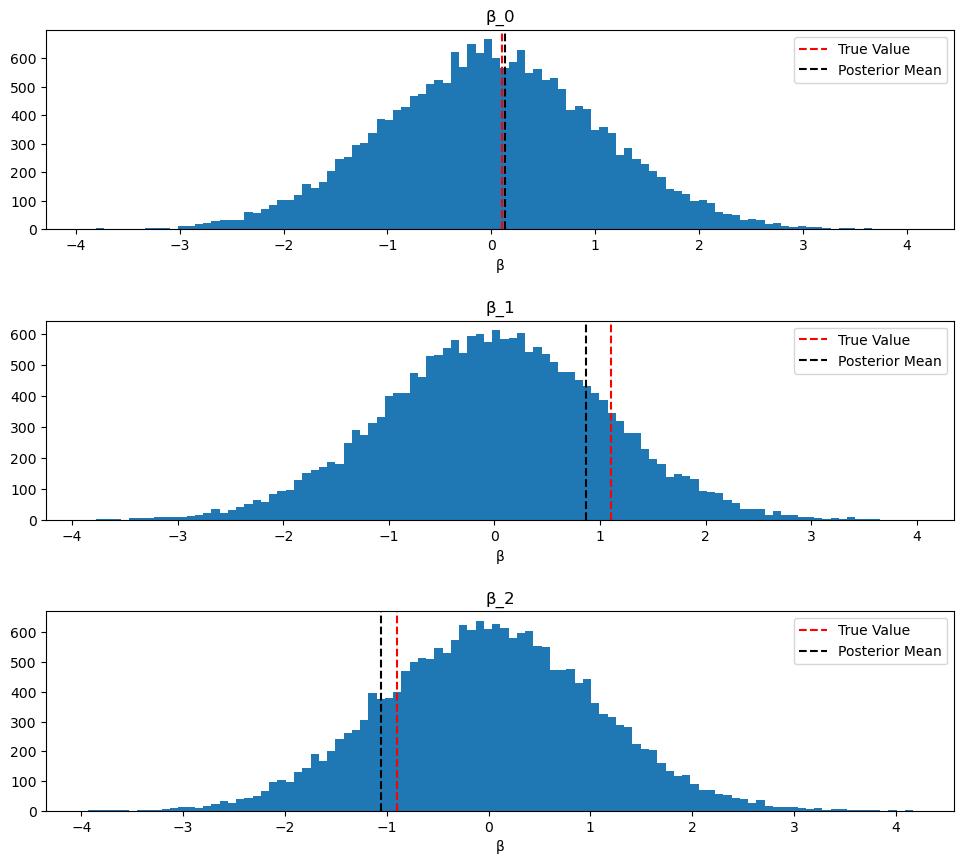

In [4]:
N = 10
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err)

Covariance of β with weights
[[ 0.12378116  0.01188395 -0.01586665]
 [ 0.01188395  0.12074523 -0.02267544]
 [-0.01586665 -0.02267544  0.11625864]]
For N = 50:
β_0: true value = 0.1, posterior mean = 0.2672, absolute error = 0.1672, standard error = 0.0101
β_1: true value = 1.1, posterior mean = 1.0664, absolute error = 0.0336, standard error = 0.0102
β_2: true value = -0.9, posterior mean = -0.9886, absolute error = 0.0886, standard error = 0.01
The effective sample size is 647.6


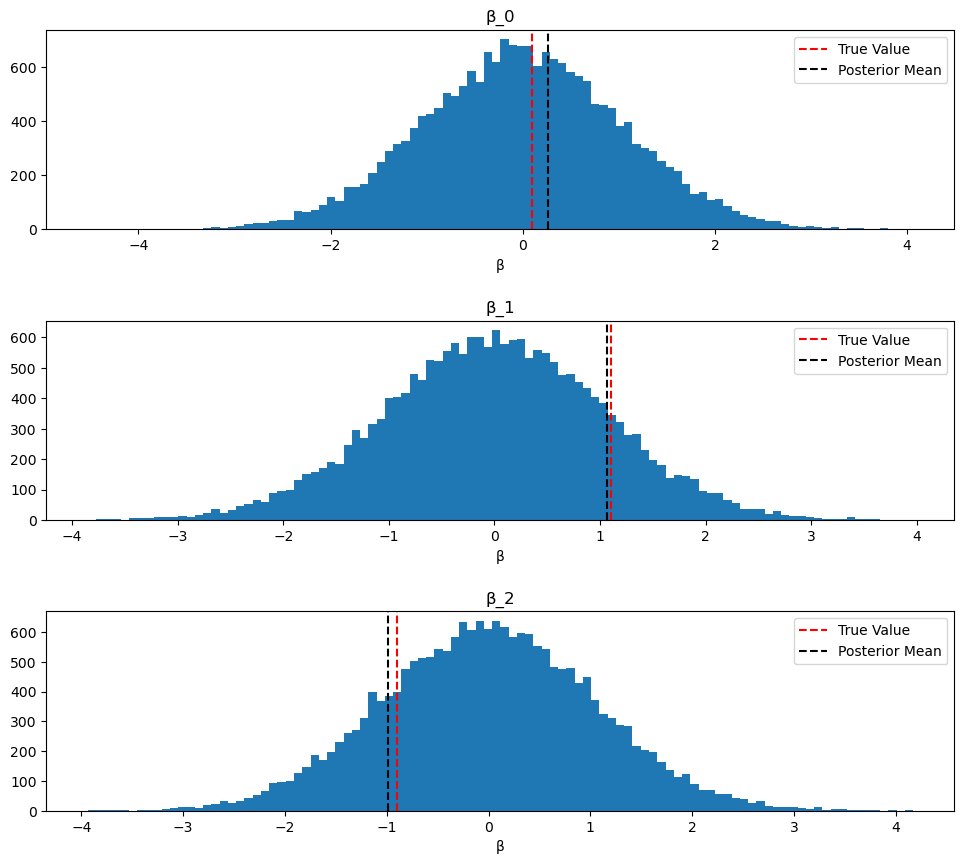

In [5]:
N = 50
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err)

Covariance of β with weights
[[ 0.07842243  0.00114442 -0.01427953]
 [ 0.00114442  0.07869707 -0.03128403]
 [-0.01427953 -0.03128403  0.07286894]]
For N = 100:
β_0: true value = 0.1, posterior mean = 0.1606, absolute error = 0.0606, standard error = 0.0151
β_1: true value = 1.1, posterior mean = 1.2409, absolute error = 0.1409, standard error = 0.0152
β_2: true value = -0.9, posterior mean = -1.3083, absolute error = 0.4083, standard error = 0.0144
The effective sample size is 172.8


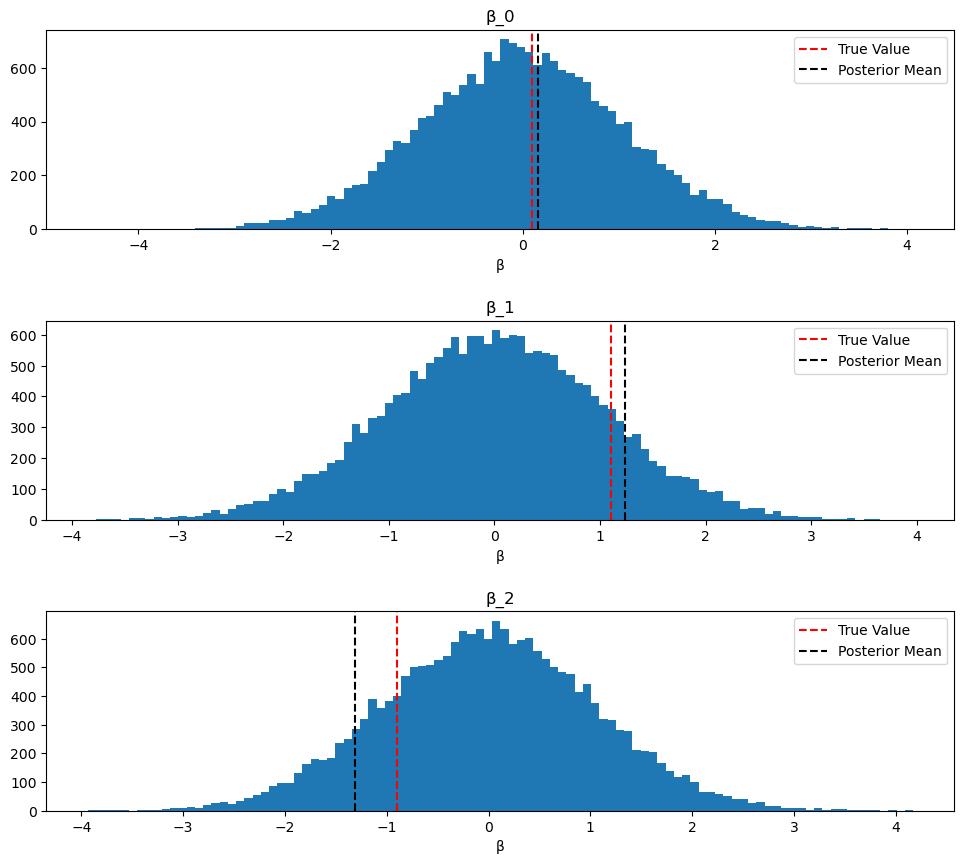

In [6]:
N = 100
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err)

In [7]:
# Attempting to find parameters through statsmodel optimizer
N = 2000
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000)

b_frame = pd.DataFrame(np.vstack([datx,daty[:,0]]),
                        index=['x1','x2','y']).T
b_frame
model = smf.logit(formula='y ~ x1 + x2',data=b_frame).fit()
print(model.summary())
print(f"""Beta found through statsmodels logit: β_0 = {
        round(model.params.iloc[0],3)},  β_1 = {
        round(model.params.iloc[1],3)},  β_2 = {round(model.params.iloc[2],3)}""")

Optimization terminated successfully.
         Current function value: 0.678791
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                0.001489
Time:                        20:45:21   Log-Likelihood:                -1357.6
converged:                       True   LL-Null:                       -1359.6
Covariance Type:            nonrobust   LLR p-value:                    0.1321
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3297      0.045      7.260      0.000       0.241       0.419
x1             0.0241      0.

In [8]:
# Attempting to find parameters through scipy optimizer
N = 100
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
popt, pcov = curve_fit(logistic, datx, daty[:,0], p0=np.ones(dof))
print(f"Beta found through scipy.optimize.curve_fit: β_0 = {round(popt[0],3)},  β_1 = {round(popt[1],3)},  β_2 = {round(popt[2],3)}")
print(pcov)

Beta found through scipy.optimize.curve_fit: β_0 = 1.0,  β_1 = 1.0,  β_2 = 1.0
[[ 8.71177826e-18 -2.41649610e-18 -4.03988579e-18]
 [-2.41649610e-18  7.02642713e-18 -1.85884316e-18]
 [-4.03988579e-18 -1.85884316e-18  7.63364923e-18]]


# 3)
The new true value of $\beta$ is $(0.1, 1.1, -0.9, 0.0909, -0.6563, 0.7059, -0.6396, 0.1774, -0.7585)$.

For $N = 10$, the estimate is $(-0.354, 1.504, -0.962, -0.533, -0.181, 0.025, -0.429, -0.028, -0.052)$ with absolute error ranging from $0.062$ to $0.706$, standard error ranging from $0.027$ to $0.032$, and effective sample size $587$.

For $N = 50$, the estimate is $(-0.2867, 0.9198, -0.6907, 0.0958, -0.4590, 0.6663, -0.7942, -0.0397, -0.3003)$ with absolute error ranging from $0.0049$ to $0.4581$, standard error ranging from $0.0654$ to $0.1326$, and effective sample size $11.6$.

For $N = 100$, the estimate is $(-0.4009, 0.7204, -0.3940, 0.0965, -0.8860, 0.8641, -1.2012, -0.0719, -0.5222)$ with absolute error ranging from $0.0055$ to $0.5616$, standard error ranging from $0.0421$ to $0.1571$, and effective sample size $3.2$.

The absolute error decreases from $N = 10$ to $N = 50$, but less consistently so to $N = 100$. Standard error again has little connection to accuracy, and all values fall well within their associated posterior distributions. The effective sample size decreases as $N$ increases, and all are smaller than for the same $N$ with $3$ parameters compared to the $9$ here.

The same issue occurs trying to use a standard optimizer; scipy's curve_fit returns the initial guess, which is a vector of ones.

[ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Covariance of β with weights
[[ 6.35243845e-01 -2.47008267e-02 -8.17101374e-02  1.80428029e-01
   7.18755711e-03 -8.43718575e-02 -2.09350912e-01  2.29544065e-03
   1.70152977e-02]
 [-2.47008267e-02  5.19887143e-01 -1.32438759e-04  2.62725694e-02
   6.31476329e-03  9.59710279e-03  6.09561659e-02  3.29666788e-02
  -1.43900883e-01]
 [-8.17101374e-02 -1.32438759e-04  6.46717276e-01 -7.46639510e-02
   8.34715879e-02 -2.22026926e-02  2.09526415e-02  2.33822974e-02
  -1.31475948e-01]
 [ 1.80428029e-01  2.62725694e-02 -7.46639510e-02  6.70433378e-01
   3.90577131e-02  8.14138885e-02 -4.01405400e-02  1.10383632e-01
  -1.71496875e-01]
 [ 7.18755711e-03  6.31476329e-03  8.34715879e-02  3.90577131e-02
   6.54217320e-01  1.11365126e-01 -1.48035368e-01 -1.00270830e-01
   4.34237364e-02]
 [-8.43718575e-02  9.59710279e-03 -2.22026926e-02  8.14138885e-02
   1.11365126e-01  5.27001932e-01  2.31144777e-02 -1.64010516e-01
  -3.91923

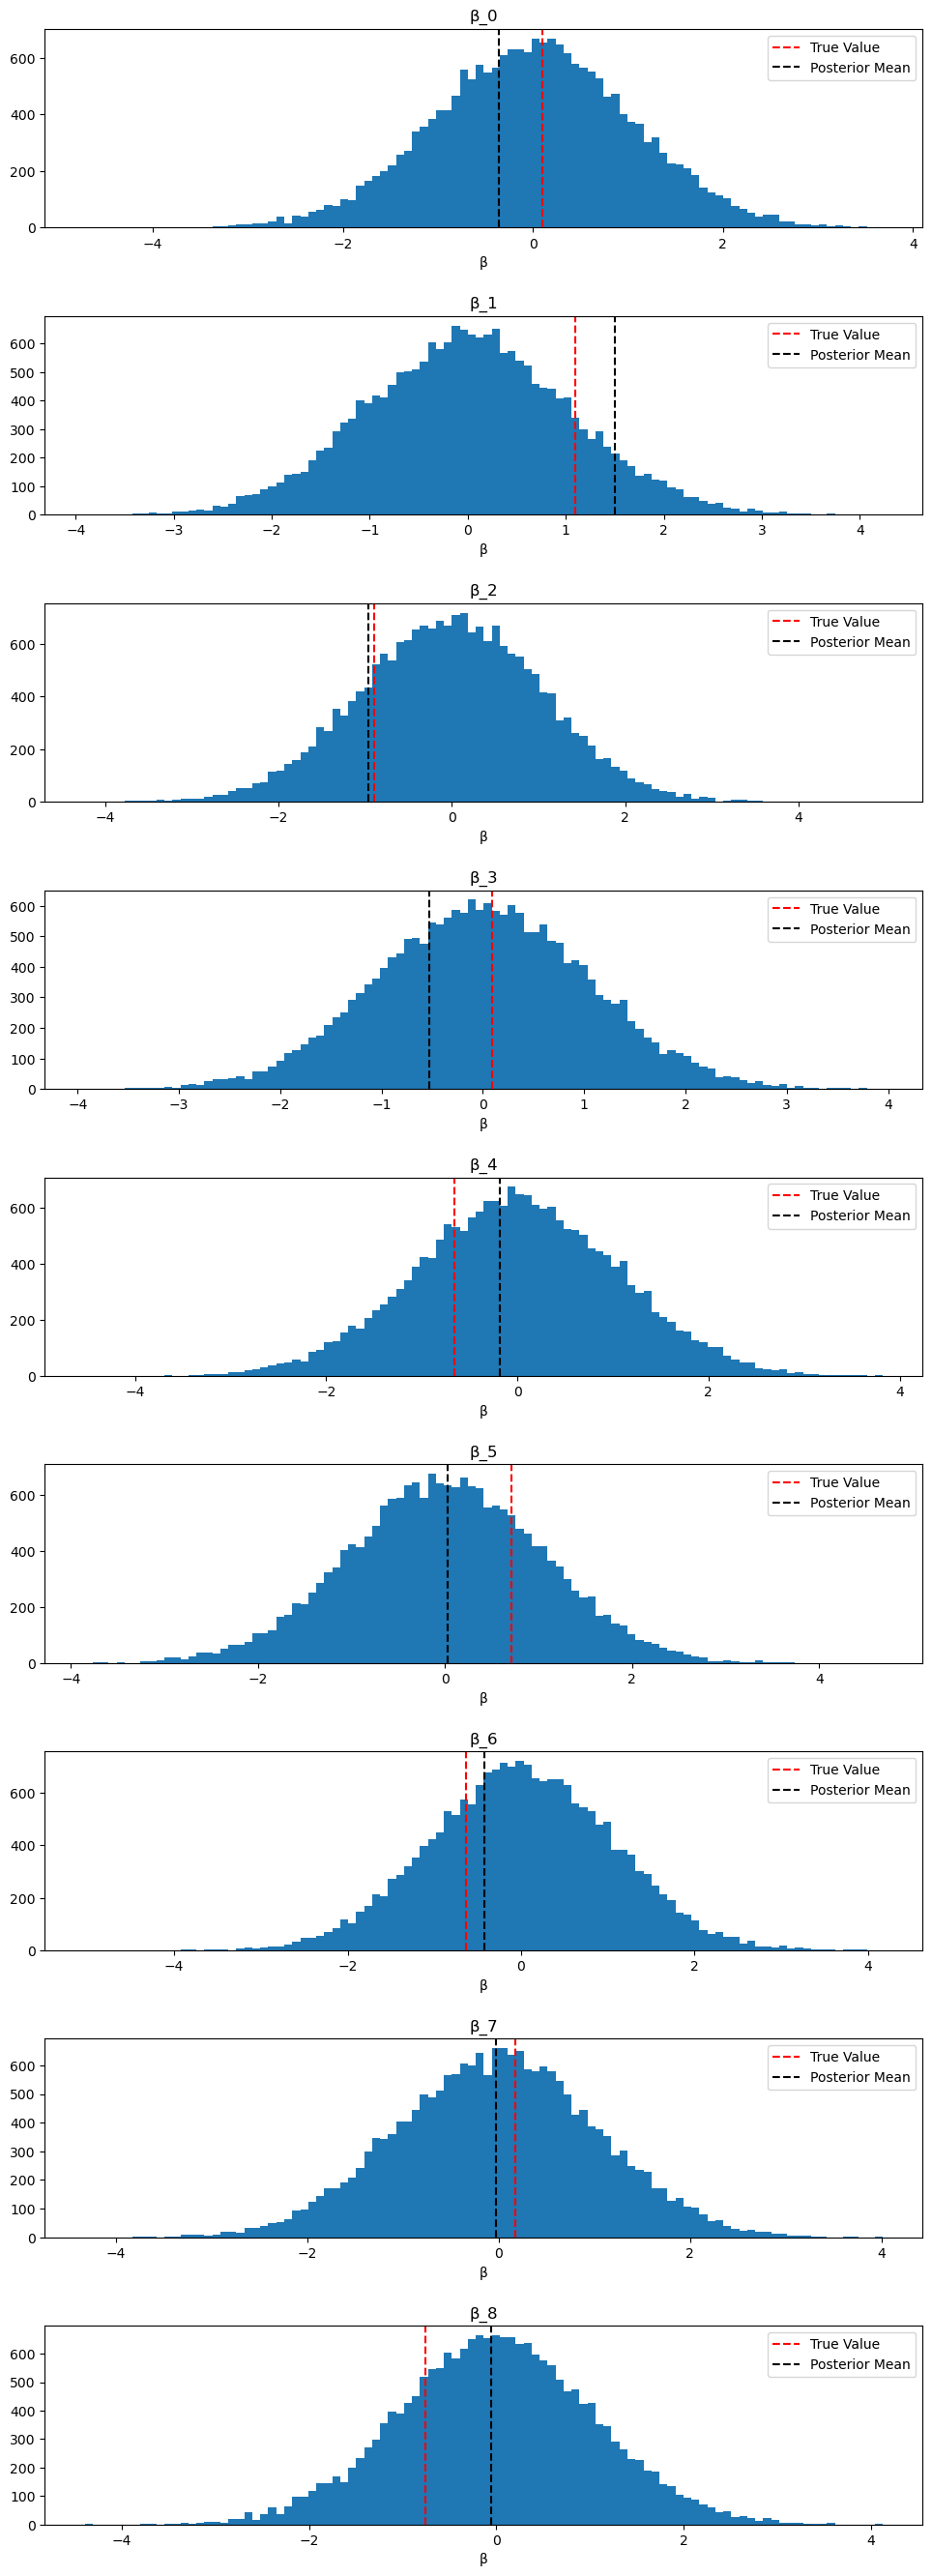

In [9]:
np.random.seed(10000)
N = 10
c = 1.1
dof = 9
beta0 = np.zeros(dof)
beta0[0:3] = [0.1,1.1,-0.9]
beta0[3:] = uniform(-1,1,dof-3)
print(np.round(beta0,4))
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err)

[ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Covariance of β with weights
[[ 0.21175833  0.00080847  0.08335302 -0.05065829 -0.04261795 -0.01467321
   0.07772381 -0.05293262 -0.03896661]
 [ 0.00080847  0.14868028  0.0140903   0.02747068 -0.02386741  0.00935354
  -0.01200975  0.02333221  0.04845085]
 [ 0.08335302  0.0140903   0.18694831 -0.01653513 -0.07376907 -0.00068105
  -0.00667599  0.03261259 -0.05845098]
 [-0.05065829  0.02747068 -0.01653513  0.08373951 -0.03861156 -0.01809939
  -0.02487537  0.03339185  0.01171827]
 [-0.04261795 -0.02386741 -0.07376907 -0.03861156  0.16378346 -0.01013249
  -0.00525365 -0.01441497  0.05323763]
 [-0.01467321  0.00935354 -0.00068105 -0.01809939 -0.01013249  0.12552902
  -0.04820581  0.03767789 -0.02542724]
 [ 0.07772381 -0.01200975 -0.00667599 -0.02487537 -0.00525365 -0.04820581
   0.11281069 -0.06978941  0.01296265]
 [-0.05293262  0.02333221  0.03261259  0.03339185 -0.01441497  0.03767789
  -0.06978941  0.12479502  0.019

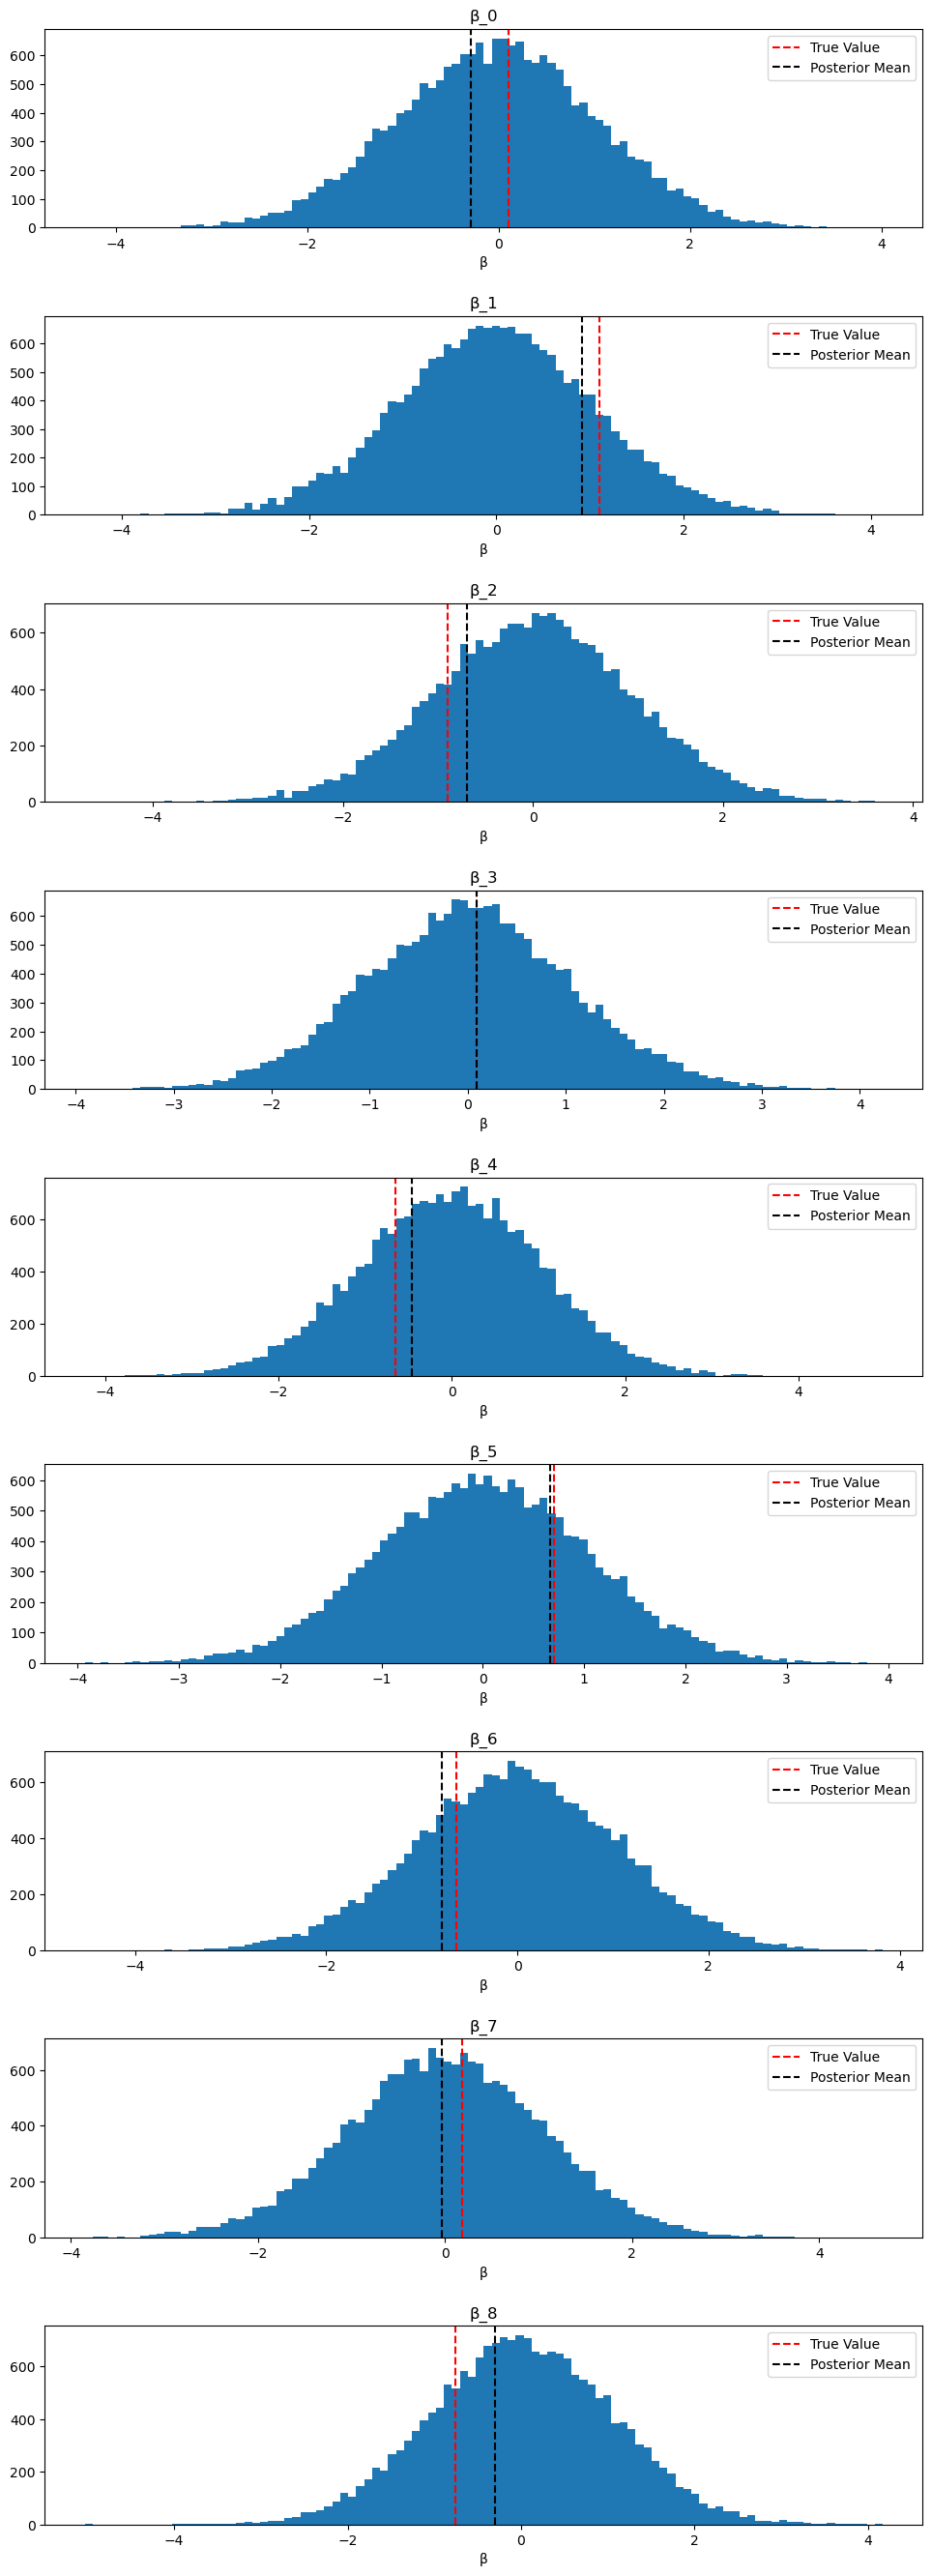

In [10]:
np.random.seed(10000)
N = 50
c = 1.1
dof = 9
beta0 = np.zeros(dof)
beta0[0:3] = [0.1,1.1,-0.9]
beta0[3:] = uniform(-1,1,dof-3)
print(np.round(beta0,4))
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err)

[ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Covariance of β with weights
[[ 0.07764622 -0.02795331 -0.08443031  0.04356724 -0.03839402 -0.02934278
   0.02659306 -0.00403665  0.00594486]
 [-0.02795331  0.09638209  0.01169881 -0.03967517 -0.04650681 -0.013004
  -0.04436186 -0.03093364  0.0459371 ]
 [-0.08443031  0.01169881  0.12938831 -0.04348648  0.05870515  0.0353782
  -0.00566988  0.01130299 -0.05726779]
 [ 0.04356724 -0.03967517 -0.04348648  0.10033265 -0.05388534 -0.01256398
   0.002726   -0.02058731 -0.03157681]
 [-0.03839402 -0.04650681  0.05870515 -0.05388534  0.13555289  0.03013355
   0.04323264  0.04850911 -0.01008637]
 [-0.02934278 -0.013004    0.0353782  -0.01256398  0.03013355  0.02194219
  -0.00544571  0.01326246 -0.01069776]
 [ 0.02659306 -0.04436186 -0.00566988  0.002726    0.04323264 -0.00544571
   0.06003387  0.01955729 -0.01713801]
 [-0.00403665 -0.03093364  0.01130299 -0.02058731  0.04850911  0.01326246
   0.01955729  0.0304545  -0.003770

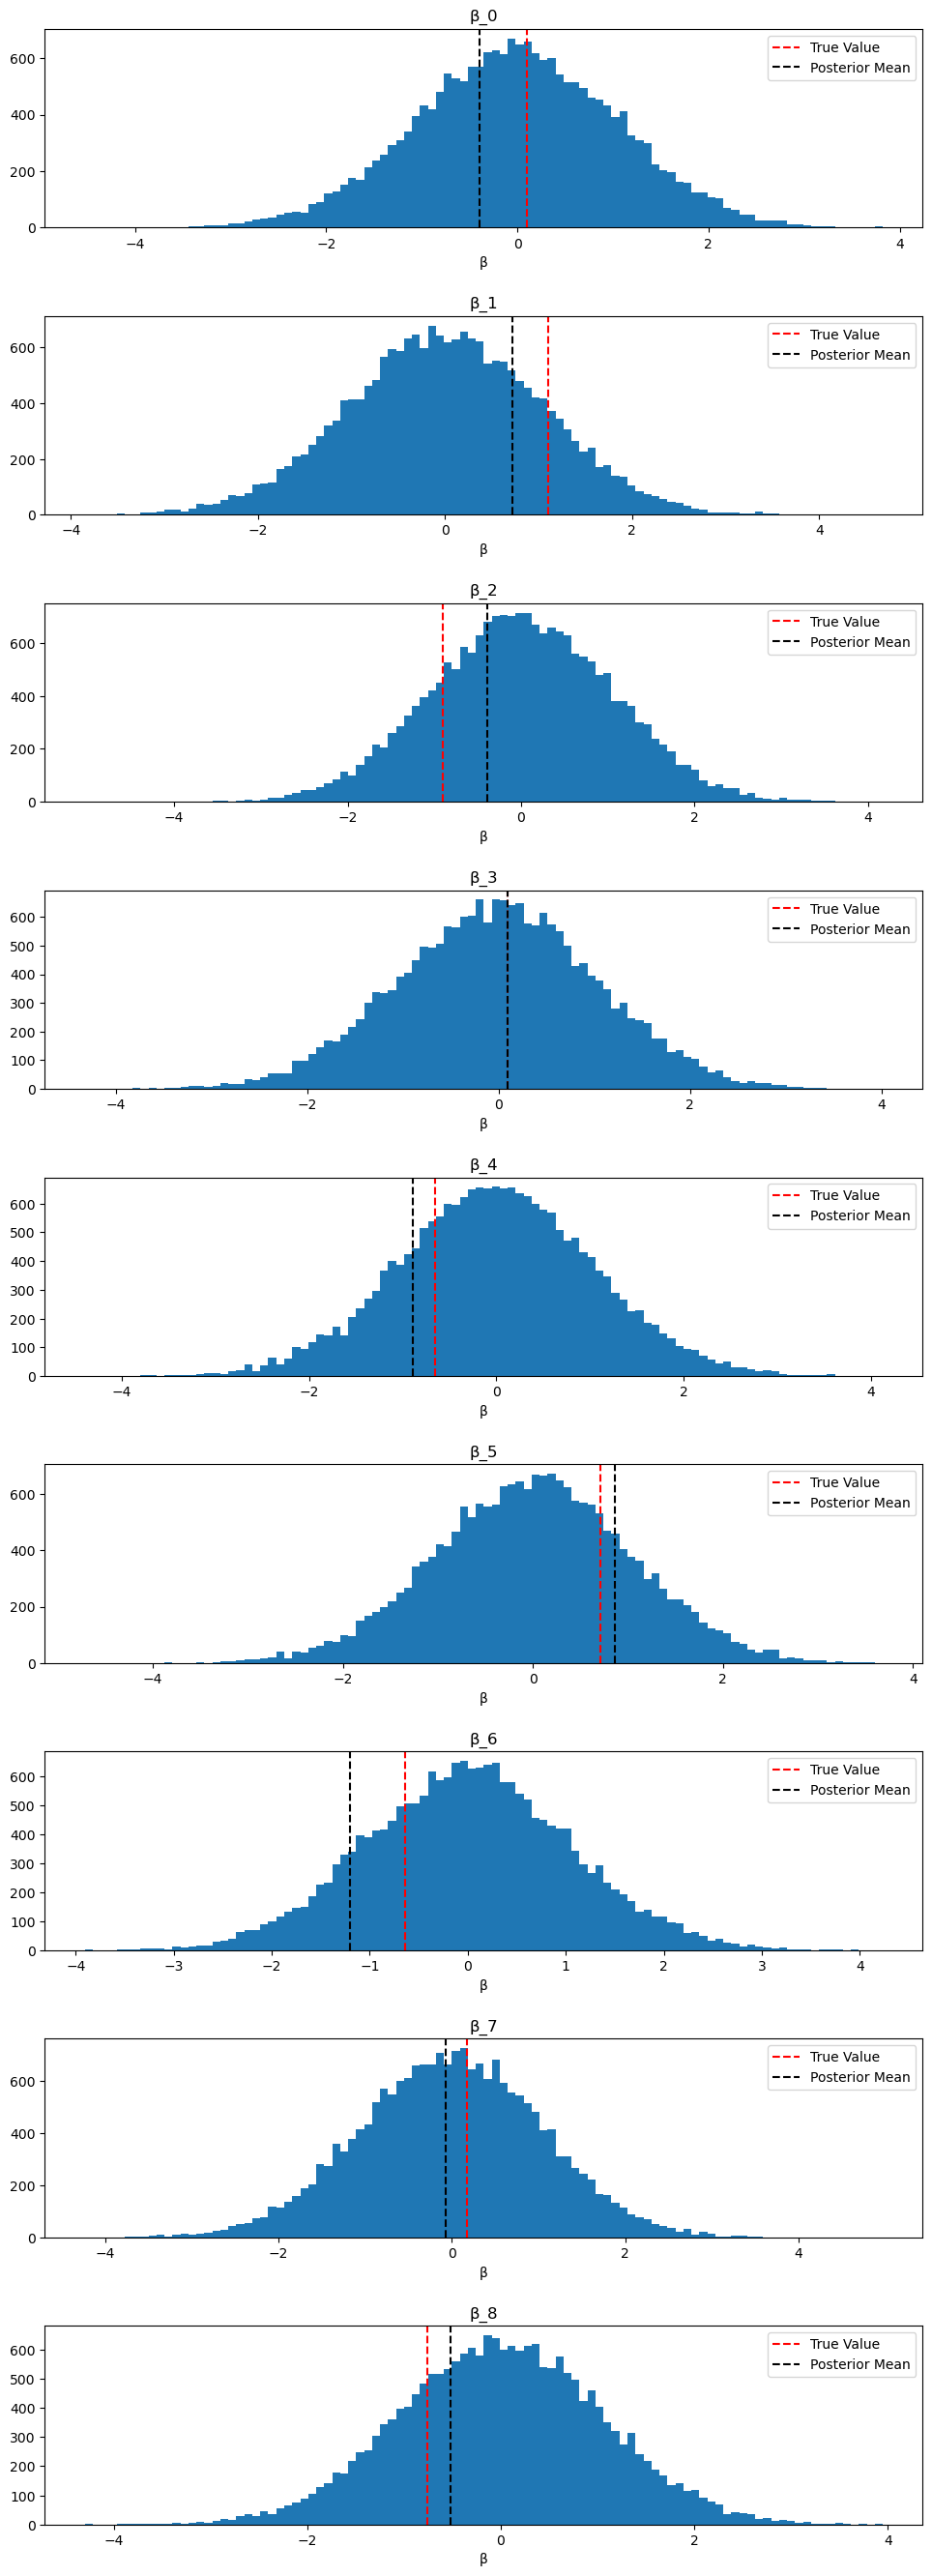

In [11]:
np.random.seed(10000)
N = 100
c = 1.1
dof = 9
beta0 = np.zeros(dof)
beta0[0:3] = [0.1,1.1,-0.9]
beta0[3:] = uniform(-1,1,dof-3)
print(np.round(beta0,4))
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err)

In [12]:
# Attempting to find parameters through scipy optimizer
N = 100
c = 1.1
dof = 9
beta0 = [0.1, 1.1, -0.9, 0.0909, -0.6563, 0.7059, -0.6396, 0.1774, -0.7585]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
popt, pcov = curve_fit(logistic, datx, daty[:,0], p0=np.ones(dof))
print(f"Beta found through scipy.optimize.curve_fit: {np.round(popt,3)}")

Beta found through scipy.optimize.curve_fit: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


# 4.)
I use scipy's minimize to attempt to locate the posterior mode, by minimizing the negative of the posterior. 

For $N = 10$, this gives a maximum in the posterior at $\beta_m = (1.3059, -0.3396, -0.7815)$. 

For $N = 50$, the mode is at $(0.4822, 1.3517, -1.8479)$.

For $N = 100$, the mode is at $(-0.0062, -0.0203, -2.1962)$.

The value of the posterior at each point is greater than its value at $\beta_0 = (0.1, 1.1, -0.9)$. The posterior in general decreases as $N$ increases. I choose to center the proposal at this mode, with the $\beta$ now being sampled from a multivariate normal with mean $\beta_m$ and variance $c=1.1$.

For $N = 10$, I now find an estimate $(0.1122, 0.8609, -1.057)$ with absolute error $(0.0122, 0.2391, 0.157)$ with effective sample size $1962$. This is an improvement in the error, relative to using a proposal with mean $0$, for the first term, and a smaller sample size (by 1300). Overall this is an improvement.

For $N = 50$, the estimate is $(0.2661, 1.0742, -0.9896)$ with error $(0.1661, 0.0258, 0.0896)$ and effective sample size $1127$. This is approximately the same error and a larger sample size (by 500). This performs more poorly.

For $N = 100$, the estimate is $(0.1305, 1.2549, -1.3030)$ with error $(0.0305, 0.1549, 0.4030)$ and effective sample size $271$. This is an improvement in the error for the first term and a larger sample size (by 100). This is a tradeoff between accuracy and sample size.

As a whole, changing to what should be a better proposal did not significantly change the results and in fact lead to a worse sample size in two of the cases, which is not the result I expected. This could mean there are not enough points to accurately determine the posterior mode, although the posterior itself changes with $N$.

I experimented a bit to see if I could get better results for $N = 50$ and $N = 100$, and it turns out I can. Instead of using the posterior mode I found for $N$ as the center of the proposal, I used the posterior mode from $N = 10$. Evaluating each posterior at this point shows that it is not a maximum for $N = 50$ or $N = 100$. However, the approximations I get for $\beta$ have similar errors to the values found at the modes, and the effective sample size is smaller.

For $N = 50$ with the proposal centered at $(0.1122, 0.8609, -1.057)$, the absolute error is $(0.1446, 0.0395, 0.0748)$ with effective sample size $400$.

For $N = 100$ with the proposal centered at $(0.1122, 0.8609, -1.057)$, the absolute error is $(0.0251, 0.1548, 0.3995)$ with effective sample size $116$.

As a whole, the absolute error did not change significantly when using the new mean $(0.1122, 0.8609, -1.057)$, but the effective sample size decreased by $30\% - 40\%$. This makes it an improvement over a proposal with mean $(0,0,0)$.

I further tested using a posterior mode for $9$ covariates. While the effective sample size was smaller for each $N$ relative to the case with $9$ covariates and a mean at the origin, the absolute errors were worse. Scipy's minimize fails to find a mode for $N = 10$ at all.

In [13]:
def max_post10(b):
    return max_post(10,b)

pt10 = minimize(max_post10,[0,0,0]).x
betas0 = [0.1,1.1,-0.9]
print(f"""Posterior mode found with scipy.optimize.minimize: β_0 = {
        round(pt10[0],4)}, β_1 = {round(pt10[1],4)}, β_2= {round(pt10[2],4)}""")
print(f"""Posterior({round(pt10[0],4)}, {round(pt10[1],4)}, {round(pt10[2],4)}) = {round(-1*max_post10(pt10),4)}""")
print(f"""Posterior({round(betas0[0],4)}, {round(betas0[1],4)}, {round(betas0[2],4)}) = {round(-1*max_post10(betas0),4)}""")
print(' ')

N = 10
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt10)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)

Posterior mode found with scipy.optimize.minimize: β_0 = 1.3059, β_1 = -0.3396, β_2= -0.7815
Posterior(1.3059, -0.3396, -0.7815) = -6.3845
Posterior(0.1, 1.1, -0.9) = -7.5778
 
Covariance of β with weights
[[ 0.42732017  0.03400128 -0.04232153]
 [ 0.03400128  0.31280945 -0.017309  ]
 [-0.04232153 -0.017309    0.51523189]]
For N = 10:
β_0: true value = 0.1, posterior mean = 0.1122, absolute error = 0.0122, standard error = 0.013
β_1: true value = 1.1, posterior mean = 0.8609, absolute error = 0.2391, standard error = 0.0105
β_2: true value = -0.9, posterior mean = -1.057, absolute error = 0.157, standard error = 0.013
The effective sample size is 1963.1


In [14]:
def max_post50(b):
    return max_post(50,b)

pt50 = minimize(max_post50,[0,0,0]).x
print(f"""Posterior mode found with scipy.optimize.minimize: β_0 = {
        round(pt50[0],4)}, β_1 = {round(pt50[1],4)}, β_2= {round(pt50[2],4)}""")
print(f"""Posterior({round(pt50[0],4)}, {round(pt50[1],4)}, {round(pt50[2],4)}) = {round(-1*max_post50(pt50),4)}""")
print(f"""Posterior({round(pt10[0],4)}, {round(pt10[1],4)}, {round(pt10[2],4)}) = {round(-1*max_post50(pt10),4)}""")
print(f"""Posterior({round(betas0[0],4)}, {round(betas0[1],4)}, {round(betas0[2],4)}) = {round(-1*max_post50(betas0),4)}""")
print(' ')

N = 50
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt50)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)

Posterior mode found with scipy.optimize.minimize: β_0 = 0.4822, β_1 = 1.3517, β_2= -1.8479
Posterior(0.4822, 1.3517, -1.8479) = -18.3667
Posterior(1.3059, -0.3396, -0.7815) = -28.0165
Posterior(0.1, 1.1, -0.9) = -27.4576
 
Covariance of β with weights
[[ 0.11414057  0.00694676 -0.01151158]
 [ 0.00694676  0.12123985 -0.02185007]
 [-0.01151158 -0.02185007  0.11786441]]
For N = 50:
β_0: true value = 0.1, posterior mean = 0.2661, absolute error = 0.1661, standard error = 0.0072
β_1: true value = 1.1, posterior mean = 1.0742, absolute error = 0.0258, standard error = 0.0076
β_2: true value = -0.9, posterior mean = -0.9896, absolute error = 0.0896, standard error = 0.0077
The effective sample size is 1127.2


In [15]:
def max_post100(b):
    return max_post(100,b)

pt100 = minimize(max_post100,[0,0,0]).x

print(f"""Posterior mode found with scipy.optimize.minimize: β_0 = {
        round(pt100[0],4)}, β_1 = {round(pt100[1],4)}, β_2= {round(pt100[2],4)}""")
print(f"""Posterior({round(pt100[0],4)}, {round(pt100[1],4)}, {round(pt100[2],4)}) = {round(-1*max_post100(pt100),4)}""")
print(f"""Posterior({round(pt10[0],4)}, {round(pt10[1],4)}, {round(pt10[2],4)}) = {round(-1*max_post100(pt10),4)}""")
print(f"""Posterior({round(betas0[0],4)}, {round(betas0[1],4)}, {round(betas0[2],4)}) = {round(-1*max_post100(betas0),4)}""")
print(' ')

N = 100
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt100)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)

Posterior mode found with scipy.optimize.minimize: β_0 = -0.0062, β_1 = -0.0203, β_2= -2.1962
Posterior(-0.0062, -0.0203, -2.1962) = -36.6626
Posterior(1.3059, -0.3396, -0.7815) = -50.3582
Posterior(0.1, 1.1, -0.9) = -48.7297
 
Covariance of β with weights
[[ 0.06686784  0.00219906 -0.01306264]
 [ 0.00219906  0.07915677 -0.03225553]
 [-0.01306264 -0.03225553  0.07802166]]
For N = 100:
β_0: true value = 0.1, posterior mean = 0.1305, absolute error = 0.0305, standard error = 0.0118
β_1: true value = 1.1, posterior mean = 1.2549, absolute error = 0.1549, standard error = 0.0124
β_2: true value = -0.9, posterior mean = -1.303, absolute error = 0.403, standard error = 0.0121
The effective sample size is 270.4


In [16]:
print("Using (1.3059, -0.3396, -0.7815)")
N = 50
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt10)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)
print(' ')

N = 100
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt10)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)

Using (1.3059, -0.3396, -0.7815)
Covariance of β with weights
[[ 0.11952749  0.00735771 -0.01127666]
 [ 0.00735771  0.12472501 -0.02527946]
 [-0.01127666 -0.02527946  0.11571875]]
For N = 50:
β_0: true value = 0.1, posterior mean = 0.2446, absolute error = 0.1446, standard error = 0.013
β_1: true value = 1.1, posterior mean = 1.0605, absolute error = 0.0395, standard error = 0.0131
β_2: true value = -0.9, posterior mean = -0.9748, absolute error = 0.0748, standard error = 0.0125
The effective sample size is 399.1
 
Covariance of β with weights
[[ 0.07549429  0.00504799 -0.01939347]
 [ 0.00504799  0.08214244 -0.04090591]
 [-0.01939347 -0.04090591  0.08548839]]
For N = 100:
β_0: true value = 0.1, posterior mean = 0.1251, absolute error = 0.0251, standard error = 0.0189
β_1: true value = 1.1, posterior mean = 1.2548, absolute error = 0.1548, standard error = 0.0201
β_2: true value = -0.9, posterior mean = -1.2995, absolute error = 0.3995, standard error = 0.0197
The effective sample size 

In [17]:
np.random.seed(10000)
N = 10
c = 1.1
dof = 9
beta0 = np.zeros(dof)
beta0[0:3] = [0.1,1.1,-0.9]
beta0[3:] = uniform(-1,1,dof-3)

pt10 = minimize(max_post10,np.zeros(dof)).x

print(f"""Posterior mode found with scipy.optimize.minimize: {np.round(pt10,4)}""")
print(f"""Posterior(β_m) = {round(-1*max_post10(pt10),4)}""")
#print(f"""Posterior({round(pt10[0],4)}, {round(pt10[1],4)}, {round(pt10[2],4)}) = {round(-1*max_post100(pt10),4)}""")
print(f"""Posterior(β_0) = {round(-1*max_post10(betas0),4)}""")
print(' ')

datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt10)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)

Posterior mode found with scipy.optimize.minimize: [ 0.1006  0.3452 -0.9487  0.1365  0.7823 -0.2451  0.7314 -0.3906  0.291 ]
Posterior(β_m) = -11.5751
Posterior(β_0) = -7.5778
 
Covariance of β with weights
[[ 6.97638220e-01  4.71162236e-04 -1.02397234e-01  1.77564487e-01
  -2.49698227e-04 -8.65831750e-02 -1.76228956e-01  2.90510380e-02
  -1.52077999e-02]
 [ 4.71162236e-04  6.02179480e-01 -2.93957377e-02  1.20006025e-02
   8.26610341e-03 -8.68467744e-03  7.44964911e-02  5.34824111e-02
  -1.36692026e-01]
 [-1.02397234e-01 -2.93957377e-02  7.20900568e-01 -1.00455843e-01
   4.84368167e-02 -3.68432222e-02  1.19960804e-02  6.13313438e-03
  -8.06721505e-02]
 [ 1.77564487e-01  1.20006025e-02 -1.00455843e-01  6.68323782e-01
   4.29428575e-02  9.60941114e-02 -5.85172400e-02  4.48670244e-02
  -1.78428088e-01]
 [-2.49698227e-04  8.26610341e-03  4.84368167e-02  4.29428575e-02
   6.55642919e-01  5.64885311e-02 -1.51262641e-01 -6.93555748e-02
   4.06275926e-02]
 [-8.65831750e-02 -8.68467744e-03 -3.6

In [18]:
np.random.seed(10000)
N = 50
c = 1.1
dof = 9
beta0 = np.zeros(dof)
beta0[0:3] = [0.1,1.1,-0.9]
beta0[3:] = uniform(-1,1,dof-3)

pt50 = minimize(max_post50,np.zeros(dof)).x

print(f"""Posterior mode found with scipy.optimize.minimize: {np.round(pt50,4)}""")
print(f"""Posterior(β_m) = {round(-1*max_post50(pt50),4)}""")
#print(f"""Posterior({round(pt10[0],4)}, {round(pt10[1],4)}, {round(pt10[2],4)}) = {round(-1*max_post100(pt10),4)}""")
print(f"""Posterior(β_0) = {round(-1*max_post50(betas0),4)}""")
print(' ')

datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt50)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)

Posterior mode found with scipy.optimize.minimize: [-0.5886  0.0758  1.0352  0.5869  0.1525  0.5256  0.7364 -0.9076  0.7525]
Posterior(β_m) = -25.2151
Posterior(β_0) = -27.4576
 
Covariance of β with weights
[[ 0.06727893  0.04250524 -0.03470583  0.00469283 -0.01807549 -0.02457228
  -0.02463529  0.03736162 -0.01401248]
 [ 0.04250524  0.84789087 -0.09252492  0.0122246  -0.42643874  0.05035408
  -0.73181724  0.34546153 -0.2120347 ]
 [-0.03470583 -0.09252492  0.09707201 -0.01567177  0.01279924  0.0237562
   0.03595037 -0.03656594 -0.00828304]
 [ 0.00469283  0.0122246  -0.01567177  0.11079625 -0.01854204  0.04121657
  -0.03167579  0.0023688  -0.00408899]
 [-0.01807549 -0.42643874  0.01279924 -0.01854204  0.29629862 -0.04111031
   0.37295183 -0.2137831   0.1196498 ]
 [-0.02457228  0.05035408  0.0237562   0.04121657 -0.04111031  0.12025789
  -0.09283303  0.04289662 -0.04620987]
 [-0.02463529 -0.73181724  0.03595037 -0.03167579  0.37295183 -0.09283303
   0.75764642 -0.30444162  0.25531529]
 [

In [19]:
np.random.seed(10000)
N = 100
c = 1.1
dof = 9
beta0 = np.zeros(dof)
beta0[0:3] = [0.1,1.1,-0.9]
beta0[3:] = uniform(-1,1,dof-3)

pt100 = minimize(max_post100,np.zeros(dof)).x

print(f"""Posterior mode found with scipy.optimize.minimize: {np.round(pt100,4)}""")
print(f"""Posterior(β_m) = {round(-1*max_post100(pt100),4)}""")
#print(f"""Posterior({round(pt10[0],4)}, {round(pt10[1],4)}, {round(pt10[2],4)}) = {round(-1*max_post100(pt10),4)}""")
print(f"""Posterior(β_0) = {round(-1*max_post100(betas0),4)}""")
print(' ')

datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling(N, c, datx, daty, dof, pt100)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err, show=False)

Posterior mode found with scipy.optimize.minimize: [ 0.2121 -0.7076  1.1781 -2.3312  1.7483  1.634   2.4576  0.1196 -0.2821]
Posterior(β_m) = -35.028
Posterior(β_0) = -48.7297
 
Covariance of β with weights
[[ 9.37772890e-01  4.77960532e-01 -7.60762409e-01  2.99068126e-01
  -1.19669434e-01  3.95770211e-02  4.24771333e-01  1.89913865e-02
   6.76056825e-01]
 [ 4.77960532e-01  2.43606363e-01 -3.87746021e-01  1.52425505e-01
  -6.09923565e-02  2.01723149e-02  2.16498158e-01  9.68151699e-03
   3.44571951e-01]
 [-7.60762409e-01 -3.87746021e-01  6.17178947e-01 -2.42621587e-01
   9.70747648e-02 -3.20964475e-02 -3.44602715e-01 -1.54037546e-02
  -5.48453478e-01]
 [ 2.99068126e-01  1.52425505e-01 -2.42621587e-01  9.54107326e-02
  -3.81498984e-02  1.25869659e-02  1.35466866e-01  6.02934001e-03
   2.15600554e-01]
 [-1.19669434e-01 -6.09923565e-02  9.70747648e-02 -3.81498984e-02
   1.52789661e-02 -5.06712246e-03 -5.42016667e-02 -2.43484672e-03
  -8.62711874e-02]
 [ 3.95770211e-02  2.01723149e-02 -3.2

# 5.)
I look at the covariance $\Sigma$ for $\beta$ with $3$ parameters to approximate the covariance of the posterior. Assuming a multivariate normal posterior, its coordinates will be dependent if $\Sigma$ has non-zero off-diagonal entries. My previous proposal had the covariance as a multiple of the identity matrix, leading to independent coordinates.

The exact entries of $\Sigma$ vary depending on $N$, but in general it seems to have signs 
$$\begin{pmatrix}
+ & + & - \\
+ & + & - \\
- & - & +
\end{pmatrix}$$

with magnitudes less than $1$. I tested different values and found that for $N=100$, using
$$\Sigma = 0.2\begin{pmatrix}
1 & 0.1 & -0.1 \\
0.1 & 1 & -0.1 \\
-0.1 & -0.1 & 1
\end{pmatrix}$$ results in an estimate $\beta = (0.1052, 0.8857, -0.9510)$ with error $(0.0052, 0.2143, 0.0510)$ and effective sample size $61$. While the error on the second component of $\beta$ is poor, the errors on the first and third components are an order of magnitude smaller than the same errors using the better posterior mode, and using the original proposal and zero-mean. The effective sample size is also smaller, meaning that using this proposal gives a significantly better result.

I tested this method for $N = 10$ and $N = 50$ with a few choices of $\Sigma$ but was only able to improve the error in one out of the three components of $\beta$ while increasing the other two. There likely is a choice of $\Sigma$ that will give a better result in these cases as well, and for the cases with $9$ parameters.

Given enough time, another approach could be to set differing components of $\Sigma$ to zero, testing whether the non-vanishing cross-terms can be set to minimize the error, and rotating through the possible non-zero components.

For N = 100:
β_0: true value = 0.1, posterior mean = 0.1052, absolute error = 0.0052, standard error = 0.0198
β_1: true value = 1.1, posterior mean = 0.8857, absolute error = 0.2143, standard error = 0.0203
β_2: true value = -0.9, posterior mean = -0.951, absolute error = 0.051, standard error = 0.0248
The effective sample size is 60.6


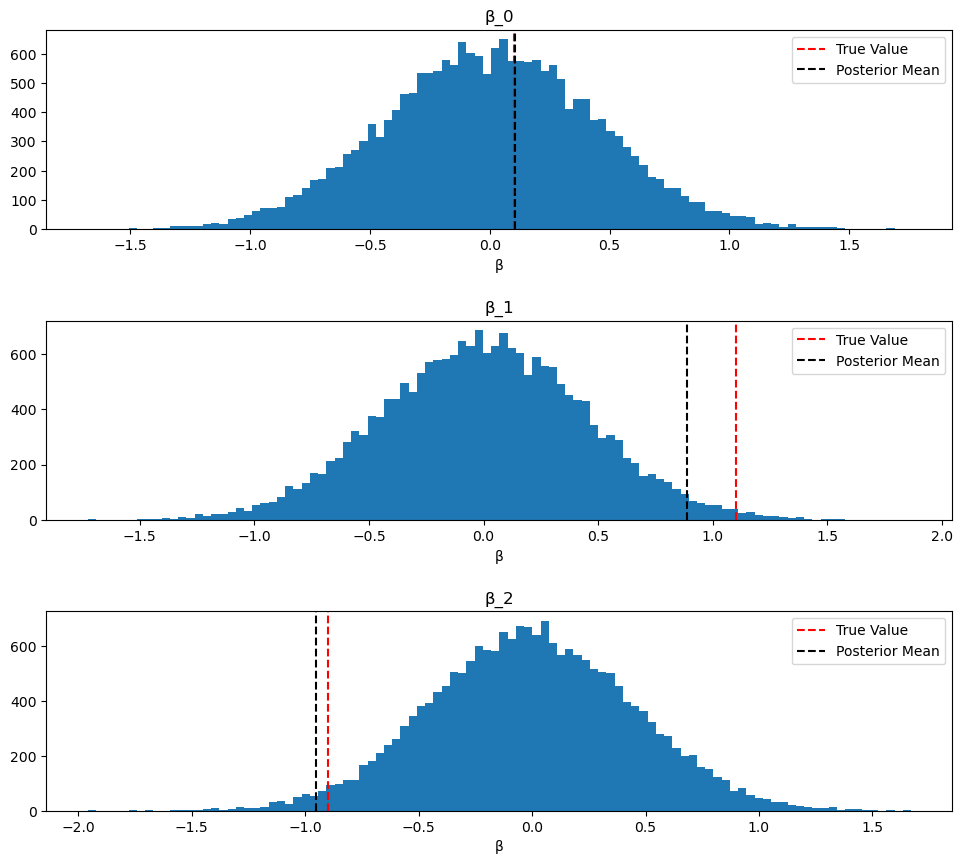

In [20]:
def log_gauss_DEPENDENT(b, sigma):
    # Log of a k-dim Gaussian with covariance sigma
    k = len(b)
    var = np.linalg.norm(sigma)
    coef = 1/(2*np.pi)**k/2 * 1/np.sqrt(var)
    return np.log(coef) - 0.5*b.T @ (sigma @ b)
        
def importance_sampling_DEPENDENT(N,sigma,datx,daty,dof,mu=None):
    # Perform importance sampling to recover the regression coefficients
    ns = 20000
    betas = np.zeros([ns,dof])
    beta_mean = np.zeros(dof)
    variance = np.zeros(dof)
    logweights = np.zeros(ns)
    logposts = np.zeros(ns)
    if type(mu) == type(None):
        mu = np.zeros(dof)

    for n in range(ns):
        # Calculate the log-weight for a given sample beta
        beta = multivariate_normal(mu,sigma)
        betas[n,:] = beta
        bi_prob = binary_prob(N, datx, beta)
        likelihood = sum([daty[0,i]*np.log(bi_prob[i]) + (1-daty[0,i])*np.log(1-bi_prob[i]) for i in range(N)])
        prior = log_gauss_DEPENDENT(beta,np.identity(3))
        proposal = log_gauss_DEPENDENT(beta,sigma)
        logweights[n] = prior + likelihood - proposal
        logposts[n] = prior + likelihood

    M = np.max(logweights)
    shifted_logw = np.exp(logweights - M)
    # Calculate the sum of the log-weights
    sum_w = sum([shifted_logw[i] for i in range(ns)])

    for j in range(dof):
        # Calculate posterior mean and variance for each coefficient
        beta_mean[j] = sum([betas[i,j]*shifted_logw[i] for i in range(ns)])/sum_w
        variance[j] = ns*sum([(shifted_logw[i]*(betas[i,j]-beta_mean[j]))**2 for i in range(ns)])/(sum_w**2)

    standard_error = np.sqrt(variance/ns)
    effective_size = sum_w**2/sum([(shifted_logw[i])**2 for i in range(ns)])
    return betas, shifted_logw, beta_mean, effective_size, standard_error

N = 100
c = 1.1
dof = 3
beta0 = [0.1,1.1,-0.9]
sigma = np.array(0.2*np.array([[1,0.1,-0.1],[0.1,1,-0.1],[-0.1,-0.1,1]]))
datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
betas, weights, beta_means, esize, err = importance_sampling_DEPENDENT(N, sigma, datx, daty, dof)
display_data(N, dof, beta0, betas, beta_means, esize, weights, err)